<a href="https://colab.research.google.com/github/pipeton8/6.439-stats-comp-applications/blob/main/Assignments/5%20-%20Environmental/6.439%20-%20Problem%20Set%205.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Set 5 - Statistics, Computation and Applications

(c) Felipe del Canto, November 2021

(c) Data from [MSEAS](http://mseas.mit.edu) at MIT.
***
***

# Part 0 (Execute first!)

In [1]:
from IPython.display import clear_output

# Download files
!wget https://github.com/pipeton8/6.439-stats-comp-applications/raw/main/Assignments/databases/PS5_data.zip
!wget https://github.com/pipeton8/6.439-stats-comp-applications/raw/main/Assignments/databases/PS5_data.z01
!wget https://github.com/pipeton8/6.439-stats-comp-applications/raw/main/Assignments/databases/PS5_data.z02
!wget https://github.com/pipeton8/6.439-stats-comp-applications/raw/main/Assignments/databases/PS5_data.z03
!wget https://github.com/pipeton8/6.439-stats-comp-applications/raw/main/Assignments/databases/PS5_data.z04
!wget https://github.com/pipeton8/6.439-stats-comp-applications/raw/main/Assignments/databases/PS5_data.z05
!wget https://github.com/pipeton8/6.439-stats-comp-applications/raw/main/Assignments/databases/PS5_data.z06
!wget https://github.com/pipeton8/6.439-stats-comp-applications/raw/main/Assignments/databases/PS5_data.z07

# Unzip
!zip -F PS5_data.zip -O PS5_data_combined.zip
!unzip -o PS5_data_combined.zip -d PS5_data
!rm *.z* -r __MACOSX PS5_data/__MACOSX

# Clear output
clear_output()

# Import packages
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

# Data path
data_path = "PS5_data/"

## Functions

In [2]:
def load(filename, file_path = data_path):
  return np.genfromtxt(file_path+filename, delimiter=",")

In [3]:
def compute_flow_cov(data_type, init_coord, max_distance, out_type = 'corr'):
  """ 
  Given the 2-tuple `init_coord` (x,y) and maximum distance `max_distance`, compute the
  covariance of `data_type` between point at coordinates `coord` and points within `max_distance`
  of it (distance is computed using L1-distance). Argument `data_type` can be 'u'
  for horizontal flow, 'v' for vertical flow, or 's' for speed.

  Argument `out_type` can be 'cov' for returning covariance and 'corr' for returning
  correlation.

  Warning: If `max_distace` is greater than the maximum allowed for `init_coord` and
  the data shape, then it is automatically shrinked to the smallest value that
  returns a square covariance matrix.
  """

  # Obtain coordinates
  x, y = init_coord

  # Obtain data (stack of data type for all times t)
  # shape of data is (max_y, max_x, T)
  data = obtain_cov_data(data_type=data_type)

  # If distance is more than allowed, shrink to fit
  max_x = data.shape[1] - 1
  max_y = data.shape[0] - 1

  max_distance_x = min([max_distance, max_x - x, x])
  max_distance_y = min([max_distance, max_y - y, y])

  max_distances = [max_distance_x, max_distance_y]

  # Compute covariance
  init_coord_values = data[y,x,:]

  E_xy = np.mean(data*init_coord_values, axis=2)
  E_x  = np.mean(data, axis=2)
  E_y  = np.mean(init_coord_values)

  cov = E_xy - E_x * E_y

  # If asking for covariance, return it
  if out_type == 'cov':
    return cov, max_distances

  elif out_type == 'corr':
    # Compute variance and SD of data
    variance = np.mean(data**2,axis=2) - np.mean(data,axis=2)**2
    sd = np.sqrt(variance)

    # Compute variance and SD of init_coord_values
    variance_init_coord = np.mean(init_coord_values**2) - np.mean(init_coord_values)**2
    sd_init_coord = np.sqrt(variance_init_coord)

    # return correlation
    return cov / (sd * sd_init_coord), max_distances
  
  else:
    raise ValueError("out_type must be 'cov' or 'corr'.")


def obtain_cov_data(data_type):
  """
  Given `data_type`, returns array with size (max_y, max_x, T), where max_x and
  max_y are the number of columns and rows (respectively) of each file in 
  PS5_data, and T is the total number of measurements (in this case T = 100).

  The returned array has values in cmps units.
  """

  # Parameters
  T = 100

  # If asked for speed data, recursively obtain horizontal and vertical flows
  # and compute speed
  if data_type == 's':
    u_data = obtain_cov_data('u')
    v_data = obtain_cov_data('v')

    cov_data = np.sqrt(u_data**2 + v_data**2)

    return cov_data

  # Obtain shape
  max_y, max_x = np.shape(load('1'+data_type+'.csv'))
  return_shape = (max_y, max_x, T)

  # Initialize matrix to return 
  cov_data = np.zeros(return_shape)

  # Fill return matrix
  for t in tqdm(range(T), desc="Filling cov_data", leave=False):
    cov_data[:,:,t] = load(f'{t+1}{data_type}.csv')
  
  # Return with unit correction
  return cov_data * 25/0.9


# Problem 5.1: Flows and corelations

## (a) and (b): visualization

The first step is to compute the average flow over time. In all matrices, the index (0,0) corresponds to the **bottom left** of each plot. Additionally, all values of each matrix are multiplied by $\frac{25}{0.9}$ for them to be in cm/second (cmps) units.

In order to gain a better sense of the strength of the currents, two different average speeds are computed. First, the average of all speed values over time. In other words, the speed is computed *before* averaging. Second, the speed of the average flow. This is, compute the speed *after* averaging the flow vectors.

In [4]:
# Parameters
max_T = 100
max_x = 555
max_y = 504

# Initialize average values
u_average = np.zeros((max_y, max_x))
v_average = np.zeros((max_y, max_x))

# Average speed
speed_average = np.zeros((max_y, max_x))

for t in tqdm(range(1, max_T+1)):
  # Load flow data for time t
  new_u, new_v = load(f'{t}u.csv'), load(f'{t}v.csv')

  # Convert to cmps
  new_u *= 25/0.9
  new_v *= 25/0.9

  # Update averages
  u_average += (1/max_T) * new_u
  v_average += (1/max_T) * new_v

  # Update speeds
  speed_average += (1/max_T) * np.sqrt(new_u**2 + new_v**2)

# Compute speeds
speed_of_average = np.sqrt(u_average**2 + v_average**2)

# Load mask for land plotting
mask = load("mask.csv")

  0%|          | 0/100 [00:00<?, ?it/s]

The image below shows some of the vectors than comprise the 2-D vector field of currents. The speed of the average flow (the second one in the paragraph above) is represented by the color of the arrows, according to the color bar at the right. 

The fastest flow is present running from east to west on the southern end of the Archipielago (around 300 km east of the initial coordinate). There is also a strong current around the islands to the southwest (around 100 km north of the initial coordinate) Other important flows run on the east, mostly going south. There are lesser important but prevalent currents running almost in circular patterns at the center and the west and at the center-north, on the east.

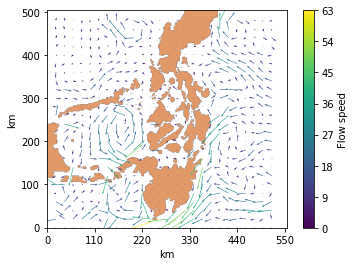

In [5]:
# Arrow positions
arrows_every = 20
x = [arrows_every * k for k in range(max_x//arrows_every)]
y = [arrows_every * k for k in range(max_y//arrows_every)]

# Initialize figure
fig, ax = plt.subplots()

# Obtain land coloration
land = np.zeros((max_y,max_x,4))
land[mask == 0] = [0.89, 0.60, 0.41, 1.]	

# Draw quiver
plt.quiver(x,y,u_average[y][:,x],v_average[y][:,x], speed_of_average[y][:,x])

# Draw map
plt.imshow(np.flip(land,0))
plt.gca().invert_yaxis()

# Show and edit colorbar
cbar = plt.colorbar(ax=ax, ticks=[9*k for k in range(8)])
cbar.set_label("Flow speed")
plt.clim(0,63)

# Set axis ticks and labels
ax.set_xlabel("km")
ax.set_xticks([110*k for k in range(6)])

ax.set_ylabel("km")

# Show image
plt.show()

The figure below shows the average speed (the first one in the paragraph that introduced this subsection). The patters shown in the previous picture still hold. The most strong currents are present n the southern part of the Archipielago, and in the islands at the south west (around 100 km to the north of the initial coordinates)

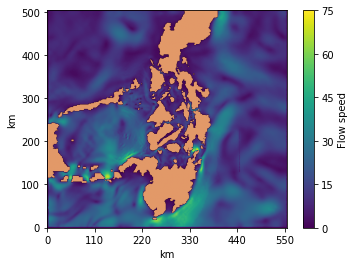

In [6]:
# Initialize figure
fig, ax = plt.subplots()

# Obtain land coloration
land = np.zeros((max_y,max_x,4))
land[mask == 0] = [0.89, 0.60, 0.41, 1.]

# Draw matrix
pos = plt.imshow(speed_average, cmap='viridis', vmin=0, vmax=75)

# Draw map on top of matrix
plt.imshow(np.flip(land,0))
plt.gca().invert_yaxis()

# Show and edit colorbar
cbar = plt.colorbar(pos, ax=ax, ticks = [15*k for k in range(6)])
cbar.set_label("Flow speed")

# Set axis ticks and labels
ax.set_xlabel("km")
ax.set_xticks([110*k for k in range(6)])

ax.set_ylabel("km")

# Show image
plt.show()

## (c): Study spatial correlations

The first step is to compute the correlations. This will be done for three variables: the horizontal flow, the vertical flow and the speed.  

In [29]:
# Parameters
x_1, y_1 = 140, 115
x_2, y_2 = 400, 400
max_distance = 100

# Compute correlations for first coordinate
corr_u_1,     max_distances_1 = compute_flow_cov(data_type= 'u', init_coord=(x_1,y_1), max_distance=max_distance)
corr_v_1,     _                 = compute_flow_cov(data_type= 'v', init_coord=(x_1,y_1), max_distance=max_distance)
corr_speed_1, _                 = compute_flow_cov(data_type= 's', init_coord=(x_1,y_1), max_distance=max_distance)

# Compute correlations for second coordinate
corr_u_2,     max_distances_2 = compute_flow_cov(data_type= 'u', init_coord=(x_2,y_2), max_distance=max_distance)
corr_v_2,     _               = compute_flow_cov(data_type= 'v', init_coord=(x_2,y_2), max_distance=max_distance)
corr_speed_2, _               = compute_flow_cov(data_type= 's', init_coord=(x_2,y_2), max_distance=max_distance)

Filling cov_data:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


Filling cov_data:   0%|          | 0/100 [00:00<?, ?it/s]

Filling cov_data:   0%|          | 0/100 [00:00<?, ?it/s]

Filling cov_data:   0%|          | 0/100 [00:00<?, ?it/s]

Filling cov_data:   0%|          | 0/100 [00:00<?, ?it/s]

Filling cov_data:   0%|          | 0/100 [00:00<?, ?it/s]

Filling cov_data:   0%|          | 0/100 [00:00<?, ?it/s]

Filling cov_data:   0%|          | 0/100 [00:00<?, ?it/s]

Horizontal flow correlation


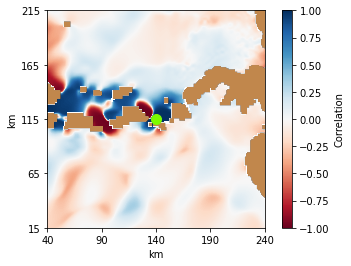


Vertical flow correlation


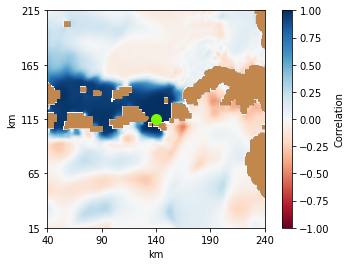


Speed correlation


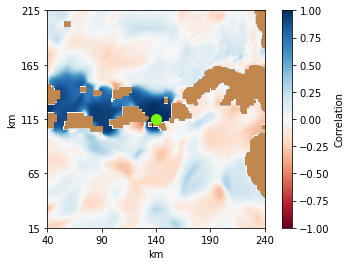

In [46]:
# Parameters
xlimits = [x_1-max_distances_1[0], x_1+max_distances_1[0]]
xstep = 50

ylimits = [y_1-max_distances_1[1], y_1+max_distances_1[1]]
ystep = 50

corrs_1 = [corr_u_1, corr_v_1, corr_speed_1]
names = ['Horizontal flow', 'Vertical flow', 'Speed']

# Loop to create images
for corr, name in zip(corrs_1, names):
  print(f"{name} correlation")

  # Initialize figure
  fig, ax = plt.subplots()

  # Obtain land coloration
  land = np.zeros((max_y,max_x,4))
  land[mask == 0] = [0.76, 0.53, 0.30, 1.]	

  # Draw point
  plt.scatter(x_1, y_1, s=100, marker='o', c='lawngreen')

  # Draw matrix
  pos = plt.imshow(corr, cmap='RdBu', vmin=-1, vmax=1)

  # Draw map on top of matrix
  plt.imshow(np.flip(land,0))
  plt.gca().invert_yaxis()

  # Show and edit colorbar
  cbar = plt.colorbar(pos, ax=ax, ticks=[-1 + 0.25*k for k in range(9)])
  cbar.set_label("Correlation")

  # Set axis ticks and labels
  ax.set_xlabel("km")
  ax.set_xlim(left=xlimits[0], right=xlimits[1])
  ax.set_xticks(np.arange(xlimits[0], xlimits[1]+1, xstep))

  ax.set_ylabel("km")
  ax.set_ylim(bottom=ylimits[0], top=ylimits[1])
  ax.set_yticks(np.arange(ylimits[0], ylimits[1]+1, ystep))

  # Show image
  plt.show()

  print("")

Horizontal flow correlation


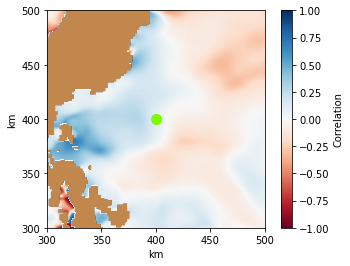


Vertical flow correlation


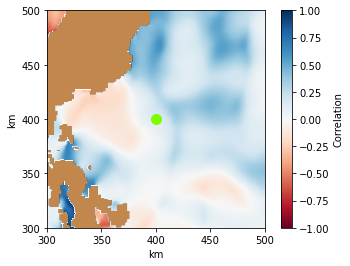


Speed correlation


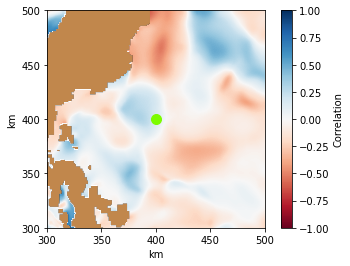

In [42]:
# Parameters
xlimits = [x_2-max_distances_2[0], x_2+max_distances_2[0]]
xstep = 50

ylimits = [y_2-max_distances_2[1], y_2+max_distances_2[1]]
ystep = 50

corrs_2 = [corr_u_2, corr_v_2, corr_speed_2]
names = ['Horizontal flow', 'Vertical flow', 'Speed']

# Loop to create images
for corr, name in zip(corrs_1, names):
  print(f"{name} correlation")

  # Initialize figure
  fig, ax = plt.subplots()

  # Obtain land coloration
  land = np.zeros((max_y,max_x,4))
  land[mask == 0] = [0.76, 0.53, 0.30, 1.]	

  # Draw point
  plt.scatter(x_2, y_2, s=100, marker='o', c='lawngreen')

  # Draw matrix
  pos = plt.imshow(corr, cmap='RdBu', vmin=-1, vmax=1)

  # Draw map on top of matrix
  plt.imshow(np.flip(land,0))
  plt.gca().invert_yaxis()

  # Show and edit colorbar
  cbar = plt.colorbar(pos, ax=ax, ticks=[-1 + 0.25*k for k in range(9)])
  cbar.set_label("Correlation")

  # Set axis ticks and labels
  ax.set_xlabel("km")
  ax.set_xlim(left=xlimits[0], right=xlimits[1])
  ax.set_xticks(np.arange(xlimits[0], xlimits[1]+1, xstep))

  ax.set_ylabel("km")
  ax.set_ylim(bottom=ylimits[0], top=ylimits[1])
  ax.set_yticks(np.arange(ylimits[0], ylimits[1]+1, ystep))

  # Show image
  plt.show()

  print("")

# Problem 5.2: Predicting trajectories.